In [3]:
# @title Imports (numpy, matplotlib, brian2)
import numpy as np
import matplotlib.pyplot as plt
!pip install brian2
from brian2 import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00


# 3. Synapses are dynamic: synaptic plasticity

Synapses are not static. They change on short and long timescales, affecting the strength of synaptic transmission.

Examples of synaptic dynamics on short timescales:
* short-term plasticity (STP)
* neuromodulation

Examples of synaptic dynamics on long timescales:
* long-term plasticity (e.g. Hebbian plasticity)
* homeostasis
* structural plasticity

---

❓Question: What quantities at synapses can change? How could we model this?

---

## 3.1 Ad-hoc synaptic plasticity


For this tutorial we focus on long-term synaptic plasticity, which is typically modelled by changing the synaptic weights ($w$).

---

🟦 **Exercise 3.1: Change the synaptic weight $w$ in the LIF neuron model with Poisson input using the slider below.**

- First review the dynamics of the LIF neuron. What kind of synapse is implemented?
- What happens to the firig rate of the neuron when $w$ is varied?

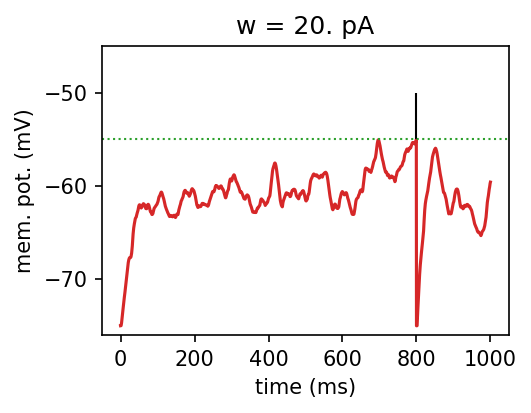

In [ ]:
#@title Varying the synaptic input weight { run: "auto", vertical-output: true, display-mode: "both" }

# input parameters
N_ext = 50
rate_ext = 15 * Hz
w_val = 20  # @param {type:"slider", min:0, max:50, step:5}
w = w_val * pA

# neuron parameters
V_th =    -55. * mV
V_reset = -75. * mV
tau_ref =   2. * ms

# start brian2 scope
start_scope()

# set up equations for a LIF neuron
LIF_eq = '''
         dv/dt = (-(v-E_L) + I/g_L)/tau_m : volt (unless refractory)
         dI/dt = -I/tau_AMPA : ampere
         tau_m : second
         E_L : volt
         g_L : siemens
         tau_AMPA : second
         '''

# create the LIF neuron
LIFNeuron = NeuronGroup(1, LIF_eq, threshold='v>V_th', reset='v = V_reset', refractory=tau_ref,
                method='exact')

# set values of the LIF neuron, they are attributes of the object
LIFNeuron.tau_m = 20 * ms # membrane time constant
LIFNeuron.E_L = -75. * mV # resting membrane potential
LIFNeuron.v = -75. * mV # initial membrane potential
LIFNeuron.g_L = 10. * nS # leak conductance
LIFNeuron.tau_AMPA = 10. * ms # time constant of excitatory synapses

# create the Poisson input neurons
InputNeurons = PoissonGroup(N_ext, rate_ext)

# we are ready for synapses!
syn = Synapses(InputNeurons, LIFNeuron, on_pre='I += w')
syn.connect()

# set up monitors
spikemon_input = SpikeMonitor(InputNeurons)
spikemon_output = SpikeMonitor(LIFNeuron)
statemon = StateMonitor(LIFNeuron, 'v', record=True)

# run FF network
run(1000 * ms)

# plot results
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=150, sharex=True)
# membrane potential
ax.plot(statemon.t/ms, statemon.v[0]*1000, c='C3')
for ti in spikemon_output.t:
    ax.vlines(ti/ms, -55, -50, ls='-', color='k', lw=1)
ax.axhline(V_th/mV, ls=':', c='C2', lw=1)
ax.set(ylabel='mem. pot. (mV)', ylim=[-76, -45], xlabel='time (ms)',
       title=f"w = {w}")
plt.show()

## 3.2 Hebbian plasticity

<div>
<img src="https://pbs.twimg.com/media/GAvzA52WYAAQNTI.jpg" width="400">
</div>

That's not quite the original quote, but it's a lot easier to remember. The original quote by Donald Hebb from 1949 reads:

> When an axon of cell A is near enough to excite a cell B and repeatedly or persistently takes part in firing it, some growth process or metabolic change takes place in one or both cells such that A’s efficiency, as one of the cells firing B, is increased.

The basic idea is that if cell A makes cell B spike, the synapse between them seems useful so we want to strengthen it.

In mathematical terms, it means that the change in the synaptic weight correlates with the activity of the presynaptic neuron (cell A) and the postsynaptic neuron (cell B):

$$ \Delta w = \mathrm{pre} \times \mathrm{post}  \tag{1}$$

Lets take a break from spiking networks to get an intuition for Hebbian plasticity. We will simulate a rate-based neuron that receives input from $N_\mathrm{ext}$ presynaptic neurons. The input weights will change with Hebbian plasticity.

The activity of the one postsynaptic neuron is given by
$$ \tau \frac{dr}{dt} = - r + \sum_{j=1}^{N_\mathrm{ext}} w_j r_j \tag{2}$$
where $r_j$ is the activity of the presynaptic neurons, $\tau$ is the time constant of the postsynaptic neuron and $w_j$ the synaptic input weights.

The weights change according to:

$$ \tau_w \frac{dw_j}{dr} = r_j \ \times \ r  \ . \tag{3}$$

$\tau_w$ is the timescale of the synaptic plasticity.

---

🟦 **Exercise 3.2:** Simulate the model described above using forward Euler and plot the evolution of the weights.

Use the following parameters:
- $N_\mathrm{ext} = 1$
- $\tau = 20$ ms
- $\tau_w = 20$ s
- duration: 1 s
- integration timestep: dt = 1 ms

**Already done? Try something more advanced:**
- use Ornstein-Uhlenbeck processes for the input rates instead
- how could you change the plasticity rule to improve stability?

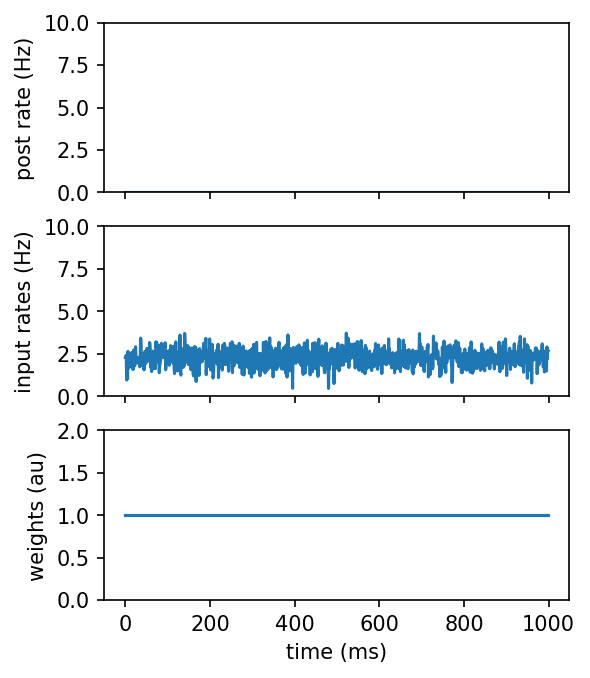

In [4]:
def simulate_Hebb_rates(duration, N_ext=1, tau=20, tau_w=20000, dt=1):
  """
  Simulate a feedforward rate network with Hebbian plasticity consisting of one
  postsynaptic neuron and N_ext presynaptic neurons. The activity of the
  presynaptic neurons is Gaussian white noise.

  Args:
  - duration (float): length of the simulation (ms)
  - N_ext (int): number of presynaptic neurons (default: 1)
  - tau (float): time constant of postsynaptic rate neuron (ms)
  - tau_w (float): time constant of Hebbian plasticity (ms)
  - dt (float): integration time step for Euler integration (ms)

  Returns:
  - t (ndarray): time array (ms)
  - r_record (ndarray): recorded activity of the postsynaptic neuron (Hz/au)
  - w_record (ndarray): array of weights over time (dim: len(t) x N_ext)
  - r_pre (ndarray): array of presynaptic neuron activites (dim: len(t) x N_ext)
  """

  # time vector
  t = np.arange(0, duration, dt)

  # input rates (Gaussian white noise with means between 2 and 4 Hz)
  r_pre = np.random.normal(3, 0.5, size=(len(t), N_ext))
  mean_shift = np.random.uniform(-1, 1, size=(1, N_ext))
  r_pre += np.tile(mean_shift, (len(t), 1))

  # initial value of post neuron rate
  r = 0

  # initial values of weights
  w = np.ones(N_ext)*1

  # arrays to record the post neuron rate and input weights
  r_record = np.zeros(len(t))
  w_record = np.zeros((len(t), N_ext))

  # time integration
  for i in range(len(t)):

    ### YOUR SOLUTION HERE >>>


    ### <<< YOUR SOLUTION HERE

    # record rate and weights
    r_record[i] = r
    w_record[i, :] = w

  return t, r_record, w_record, r_pre


t, r, w, r_pre = simulate_Hebb_rates(1000, N_ext=1)

# plotting
fig, ax = plt.subplots(3, 1, figsize=(4, 5), dpi=150, sharex=True)
ax[0].plot(t, r)
ax[1].plot(t, r_pre)
ax[2].plot(t, w)

# set limits and add labels
ax[0].set(ylim=[0, 10], ylabel='post rate (Hz)')
ax[1].set(ylim=[0, 10], ylabel='input rates (Hz)')
ax[2].set(ylim=[0, 2], ylabel='weights (au)', xlabel='time (ms)')

plt.show()


#### Hints

- the input rates should be Gaussian white processes with different means
- as initial values for the weights use 0.1
- you can complete the implementation above or write your own

---

❓Question: What happens when you run the network with Hebbian plasticity for longer? Do you have an intuition why this happens?

---

Congratulations, you made your first little network blow up. We will come back to how this behaviour can be counteracted later, but first we will learn about Hebbian plasticity in spiking networks.


## 3.3 Spike-timing-dependent plasticity (STDP)

As the name indicates, STDP considers the timing of spikes between a presynaptic and a postsynaptic neuron. It was discovered and published in a series of papers in the 90s in experiments testing stimulation protocols with different timings (Markram and Sakmann, 1997; Bi and Poo, 1998; Sjöström et al., 2001). The idea is quite simple. Let's consider one presynaptic and one postsynaptic neuron connected by a synapse:

* If a presynaptic spike is followed by a postsynaptic spike, increase the synapse.
* If the presynaptic spike is preceded by a postsynaptic spike, decrease the synapse.

This way, we are strengthening synapses that lead the postsynaptic neuron to spike such that in the future they will be more effective at making the postsynaptic neuron spike.

<div>
<img src="https://github.com/LNaumann/tutorial_plasticity/blob/main/images/long-term-plast.png?raw=true" width="400">
</div>

### Model of STDP

How do we put this into math? STDP is typically described as a biphasic exponentially decaying function. This just means that we distinguish between the pre-post and post-pre case and change synapses depending on the time difference between the two spikes:

\begin{eqnarray}
& \Delta W &=& A_+ e^{ -(t_{post}-t_{pre})/\tau_+} &\text{if} \hspace{5mm} t_{post} > t_{pre}& \\
& \Delta W &=& -A_- e^{(t_{post}-t_{pre})/\tau_-} &\text{if} \hspace{5mm} t_{post} < t_{pre}&
\end{eqnarray}

where $\Delta W$ denotes the change in the synaptic weight and $t_{\rm pre}$ and $t_{\rm post}$ are the timings of the presynaptic and postsynaptic spikes, respectively. $A_+$ and $A_-$ determine the maximum amount of synaptic modification (which occurs when the timing difference between presynaptic and postsynaptic spikes is close to zero), $\tau_+$ and $\tau_-$ determine the ranges of pre-to-postsynaptic interspike intervals over which synaptic strengthening or weakening occurs.

Thus. when the postsynaptic spike occurs *after* the presynaptic spike, the weight change is positive: $\Delta W > 0 $.

This model captures the phenomena that repeated occurrences of presynaptic spikes within a few milliseconds **before** postsynaptic action potentials lead to long-term potentiation (LTP) of the synapse, whereas repeated occurrences of presynaptic spikes **after** the postsynaptic ones lead to long-term depression (LTD) of the same synapse.

The latency between presynaptic and postsynaptic spike ($\Delta t$) is defined as:

\begin{equation}
\Delta t = t_{\rm post} - t_{\rm pre} \quad .
\end{equation}

Note: Sometimes the latency is defined the other way round ($t_{\rm pre} - t_{\rm post}$), such that the sign switches.

To get a feeling for the STDP rule, we will first look at the weight changes it produces.

---

🟦 **Exercise 3.3: Compute the weight change for a range of pre-post spike latencies $\Delta t$.**

You can complete the code below and use the parameters specified there.

**Already done?**
* Play with the time constants $\tau_+$ and $\tau_-$. What happens?
* Play with the amplitude and sign of $A_+$ and $A_-$ to get different shapes of the plasticity window. What do they imply?



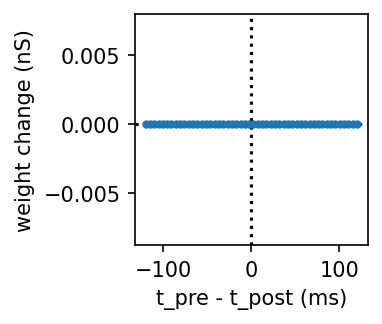

In [5]:
def compute_dW(time_diff, A_plus, A_minus, tau_plus, tau_minus):

  # empty array for STDP change
  dW = np.zeros(len(time_diff))

  ### YOUR SOLUTION BELOW >>>


  ### <<< YOUR SOLUTION ABOVE

  return dW

# STDP parameters
A_plus = 0.008                   # magnitude of LTP
A_minus = A_plus * 1.10          # magnitude of LTD
tau_plus = 20.                   # STDP time constant [ms]
tau_minus = 20.                  # STDP time constant [ms]

# range of latencies
time_diff = np.linspace(-120, 120, 50)

# call function to compute weight changes
dW = compute_dW(time_diff, A_plus, A_minus, tau_plus, tau_minus)

# plot
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
ax.plot(time_diff, dW, '.')

# limits, labels, axis lines
ax.set(xlabel='t_pre - t_post (ms)', ylabel='weight change (nS)', ylim=[-A_minus, A_plus])
ax.axvline(0, c='k', ls=':', zorder=-1)
ax.axhline(0, c='k', ls=':', zorder=-1)
plt.show()

For comparison, the STDP learning window from Bi & Poo (1998) looks like this:

<div>
<img src="https://www.researchgate.net/publication/324705724/figure/fig3/AS:618625325080577@1524503179642/Asymmetric-STDP-learning-window-Spike-timing-window-of-STDP-for-the-induction-of.png" width="400">
</div>

### Keeping track of pre- and postsynaptic spikes


Since a neuron will receive numerous presynaptic spike inputs, keeping track of the timing of all pre- and postsynaptic spikes and their contribution to the STDP rule is not trivial.

What we need to do is:

- if there is a presynaptic spike, look at all previous postsynaptic spikes and add up their contribution to the weight change
- if there is a postsynaptic spike, do the same for all previous presynaptic spikes

A convenient way to do this is to accumulate them in traces.

For each postsynaptic neuron:

\begin{equation}
\tau_{-} \frac{dz_-}{dt} = -z_-
\end{equation}

and whenever the postsynaptic neuron spikes,

\begin{equation}
z_- \rightarrow z_- + 1
\end{equation}

This way $z_-(t)$ tracks the number of postsynaptic spikes over the timescale $\tau_{-}$. So when we get a presynaptic spike, we can use this trace of postsynaptic spikes to consider all of their contributions to the weight change.

Similarly, for each presynaptic neuron, we define:

\begin{equation}
\tau_{+} \frac{dz_+}{dt} = -z_+
\end{equation}

and whenever there is spike on the presynaptic neuron,

\begin{equation}
z_+ \rightarrow z_+ + 1
\end{equation}

You can probably already guess that we will use $z_+$ for positive weight changes (the LTP part of STDP) and $z_-$ for negative weight changes (the LTD part).

---

🟦 **Exercise 3.4: Compute the trace $z_+$ for a set of presynaptic input spikes.**

- compute the trace for the spikes of one presynaptic neuron ($N=1$) in a time window of $200$ ms
- the firing rate of the presynaptic neuron is $10$ Hz
- use forward Euler to compute the traces with an integration timestep of $0.1$ ms
- to get Poisson spike trains, you can use the code supplied below

**Already done?**
- compute the traces of more than one presynaptic neuron, e.g. $N=5$

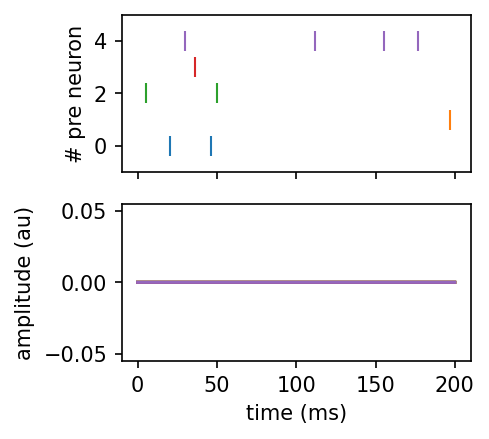

In [6]:
# helper function to create Poisson spike trains
def generate_spike_train_bool(N, rate, t_max, dt=0.1):
    num_bins = int(t_max / dt)
    spike_train_bool = np.zeros((N, num_bins), dtype=bool)

    for j in range(N):
      for bin_idx in range(num_bins):
          spike_prob = 1 - np.exp(-rate * dt)
          spike_train_bool[j, bin_idx] = np.random.rand() < spike_prob

    return spike_train_bool


# function for computing z_plus
def compute_z_plus(input_spikes, tau_plus=20, dt=0.1):

  z_plus = np.zeros(input_spikes.shape)

  ### YOUR SOLUTION BELOW >>>


  ### <<< YOUR SOLUTION ABOVE

  return z_plus


# define parameters
N = 5        # number of presynaptic neurons
rate = 10    # firing rate of presynaptic neurons (Hz)
t_max = 200  # duration (ms)
dt = 0.1     # integration time step (ms)

# create spike train(s)
spike_trains = generate_spike_train_bool(N, rate, t_max/1000, dt=dt/1000)

# compute z_plus trace(s)
z_plus = compute_z_plus(spike_trains)

# plotting
fig, ax = plt.subplots(2, 1, figsize=(3, 3), dpi=150, sharex=True)
for j in range(N):
  t_sp = np.where(spike_trains[j] == 1)[0]*dt
  ax[0].plot(t_sp, j * np.ones(len(t_sp)), '|', ms=10)
  ax[1].plot(np.arange(0, t_max, dt), z_plus[j])

ax[0].set(ylabel='# pre neuron', ylim=[-1, N])
ax[1].set(ylabel='amplitude (au)', xlabel='time (ms)')
plt.show()

## 3.4 Simulating STDP in a LIF neuron

We are getting close to the grand finale: simulating plasticity in a spiking network using Brian2!

<div>
<img src="https://vintageinspiredpassionista.files.wordpress.com/2012/04/drum-roll-please.png" width="400">
</div>

---

🟦 **Exercise 3.5: Simulate STDP on the synapse of a presynaptic Poisson neuron to a postsynaptic LIF neuron using Brian2.**

- use code snippets from previous exercises
- as a starting point, use the parameters from previous examples
- you will need to provide some constant input to your LIF neuron to make it spike if it only gets input from one Poisson neuron
- plot the membran potential of the LIF neuron, the spikes of the presynaptic neuron and the synaptic weight over time

**Already done? Try something more advanced:**

- Increase the number of presynaptic neurons and look at the weight distribution at the end of the simulation.
- Run the network for longer, what happens to the weights and/or their distrubution?
- Play with the STDP time window. What happends when $\tau_-$ and $\tau_+$ are different? What does it mean when one of them is larger?

In [7]:
# YOUR SOLUTION BELOW >>>


#### Hints

- the weight `w` should be a property of the synapse (i.e. the `Synapses` object)
- you need to model the traces `z_minus` and `z_plus`. They can be implemented in a similar way to the changes of the membrane potential `v`, but they are also properties of the synapse, not the neuron
- the `Synapses` object takes arguments `on_pre` and `on_post` describibing in a string what happens on a pre- or postsynaptic
- the `StateMonitor` can also record variables from `Synapses` objects
- (it may make sense to clip the weights between 0 and some maximum value, you can just use the function `clip` inside strings for Brian)

# (Optional) 4. Homeostatic plasticity rules

We've seen different examples where Hebbian plasticity produces unstable behaviour in the synaptic weights and therefore in the neural activity. Yet, biological networks of neurons are remarkably stable. In addition to Hebbian plasticity there are homeostatic mechanisms that maintain certain properties of the system such as stable firing rates.

> Homeostasis: a self-regulating process by which a living organism can maintain internal stability while adjusting to changing external conditions.

Homeostasis processes consist of five main components:

1. Target quantity: the property of the system that is homeostatically regulated
2. Target value: the desired value for the quantity to be maintained
3. Sensor: something that detects deviations from the target value
4. Effector: the process that controls the target
5. Rule: the rule by which the effector changes the quantity to achieve the target value

<div>
<img src="https://github.com/LNaumann/tutorial_plasticity/blob/main/images/homeostasis.jpeg?raw=true" width="600">
</div>

---

❓Question: Can you think of an example of a homeostatic process? What are the five components?

---

Homeostatic processes can target different properties of neurons, such as:
- intrinsic excitability
- number and strength of synapses
- how susceptible synapses are to changes ("meta-plasticity")

---

❓Question: Can you think of a way to put homeostasis into math and add it to a plasticity rule?

---

We will focus on the firing rate (or more generally neural activity) as a target of homeostasis.

Let's consider the synaptic weight $w$ between a presynaptic neuron with activity $x$ and a postsynaptic neuron with activity $y$.

The basic Hebbian plasticity rule is:

$$ \frac{dw}{dt} = x \cdot y$$

Now we'll extend this to include homeostasis.

### 4.1 Weight decay

To control the postsynaptic activity, we can decay the strength of synaptic changes depending on how strong it is. This means that stronger weights will decay faster and thus indirectly maintains the postsynaptic activity.

In math:

$$\frac{dw}{dt} = xy - \gamma w \tag{1}$$

---

❓Question: What is good or bad about this rule?

---

### 4.2 Synaptic scaling

Another option for controlling weight growth is to re-scale the synapses to stay within a particular range. For one synapse that seems like a stupid mechanism: change $w$ according to $\frac{dw}{dt}$ and then scale it back.

But if we have a set of input synapses $w_1, w_2, ... , w_N$ we can rescale them such that their sum is constant $\sum_i w_i = \alpha:$

$$w_i \leftarrow \frac{\alpha}{\sum_j w_j} w_i \tag{2}$$

In this way, the *relative strength* of the synapses is preserved.

**Note**: In a recurrent network, we usually scale all the ingoing synapses to each neuron.

### 4.3 The BCM rule

Now let's introduce an explicit target. One simple way is:

$$ \frac{dw}{dt} = x \cdot (y - \theta) \tag{3}$$

Where $\theta$ is the target of postsynaptic activity (or the threshold for potentiation and depression).

Instead of changing the weight according to the presynaptic and the postsynaptic activity, it changes with the presynaptic activity and the *difference* of the postsynaptic activity $y$ from its target $\theta$.

---

❓Question: What are the steady-states of Eq. (1)? What does that mean?

---

❓Question: Do you see a problem with the intuition of this plasticity rule?

---

The **BCM rule** is a homeostatic plasticity rule first proposed by **B**ienenstock, **C**ooper and **M**unroe in 1982. It's similar to Eq. (1), just with some additional terms:

$$ \frac{dw}{dt} = \eta x y (y- \theta) \tag{4}$$

$\eta$ is the learning rate, i.e. how quickly the weight changes. For a constant value $\theta$ this rule is not stable. To make sure it's stable and brings the postsynaptic activity $y$ to the target, $\theta$ will rather be a threshold of potentiation and depression that depends on $y$ and a activity target $\kappa$:

$$\theta = \frac{\bar{y}^2}{\kappa} \tag{5}$$

Instead of using the instantaneous postsynaptic activity $y$ we use an estimate $\bar{y}$ that slowly follows $y$:

$$ \tau_c \frac{d\bar{y}}{dt} = -\bar{y} + y \tag{6}$$

The time constant $\tau_c$ determines the timescale at which the activity of the postsynaptic neuron is estimated and thus determines the timescale of homeostasis.

<div>
<img src="https://github.com/LNaumann/tutorial_plasticity/blob/main/images/BCM.jpeg?raw=true" width="500">
</div>

---

# Homework

The homework that is suitable to you will depend a lot on your previous experience and how well you could follow the tutorial. Assess your level to choose your homework:

---

### Level 0: This is all new to me and I am a little lost 🐣

Go through the notebooks again and repeat the content. Ask TAs or other students for help if you're stuck.

---

### Level 1: I could follow the tutorial but could not finish the exercises 🐦

Go back to the exercises and finish them. Try a few follow-ups to get out of your comfort zone.

---

### Level 2: I feel confident with the material and want to go further 🦢

Go for the follow-up exercises one by one. If you want to try something harder, do all extensions of Exercise 3.5.

---

### Level 3: All this was easy, give me a challenge 🐉

Read through Part 4 on homeostasis. Solve the following exercise:

Model a feedforward rate network with the BCM rule. Model one postsynaptic neuron and a set of presynaptic neurons. The presynaptic neurons can have Gaussian white noise activity or be Ornstein-Uhlenbeck processes. The weights from the presynaptic neurons to the postsynaptic neuron should follow the BCM rule (Eq. (4)-(6)). Choose parameters inspired by previous exercises. Play around with those that you do not know, including initial values. Think about what is a reasonable value for the target firing rate.

Simulate your network for several seconds. See if there is some sort of trend. Plot the firing rate of your postsynaptic neuron and the weights over time. Does you model manage to stay at the target rate?

*Hint*: Make sure that the timescale of plasticity is slower than the neural dynamics. The timescale of homeostasis should be slower than the neural dynamics but faster than the plasticity. You can play around with the timescales (spoiler: they matter a lot for stability).

---